# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.utils import simple_preprocess
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, SpatialDropout1D
from keras.preprocessing.text import Tokenizer
from keras.layers import Dropout
from sklearn.utils import class_weight
from keras.layers import Bidirectional
from sklearn.preprocessing import StandardScaler

# Importing Data

### Data Collection

In [2]:
df = pd.read_csv('SPAM_text_message.csv')

In [3]:
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### Data Overview

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [5]:
df.isnull().sum()

Category    0
Message     0
dtype: int64

In [6]:
df['Category'].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

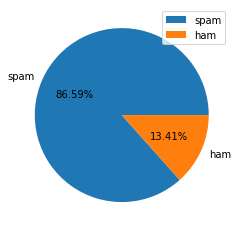

In [7]:
churn_pie = [4825, 747]
plt.pie(churn_pie, labels=['spam', 'ham'], autopct="%1.2f%%")
plt.legend()

# Data Preprocessing

In [8]:
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### Lowercasing

In [9]:
df['Message'] = df['Message'].apply(lambda x: x.lower())

### Remove Punctuation

In [10]:
df['Message'] = df['Message'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

### Remove URLs

In [11]:
def remove_urls(text):
    url_pattern = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+|www(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    return url_pattern.sub('', text)

df['Message'] = df['Message'].apply(remove_urls)

### Remove Stopwords

In [12]:
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word.lower() not in stop_words]
    return ' '.join(filtered_text)

df['Message'] = df['Message'].apply(remove_stopwords)

### Stemming

In [13]:
def stem_text(text):
    stemmer = PorterStemmer()
    word_tokens = word_tokenize(text)
    stemmed_text = [stemmer.stem(word) for word in word_tokens]
    return ' '.join(stemmed_text)

df['Message'] = df['Message'].apply(stem_text)

In [14]:
df.head()

,Category,Message
0,ham,go jurong point crazi avail bugi n great world...
1,ham,ok lar joke wif u oni
2,spam,free entri 2 wkli comp win fa cup final tkt 21...
3,ham,u dun say earli hor u c alreadi say
4,ham,nah dont think goe usf live around though


# Feature Engineering

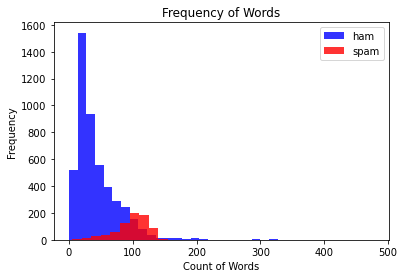

In [15]:
# Number of words
df['Total_Words'] = df.Message.apply(len)

df[df.Category=='ham'].Total_Words.plot(bins=35, kind='hist', color='blue', 
                                       label='ham', alpha=0.8)
df[df.Category=='spam'].Total_Words.plot(kind='hist', color='red', 
                                       label='spam', alpha=0.8)
plt.legend()
plt.title('Frequency of Words')
plt.xlabel("Count of Words");

In [16]:
# Number of distinct words
def count_distinct_words(text):
    words = text.split()
    distinct_words = set(words)
    return len(distinct_words)

df['Distinct_Words'] = df['Message'].apply(count_distinct_words)

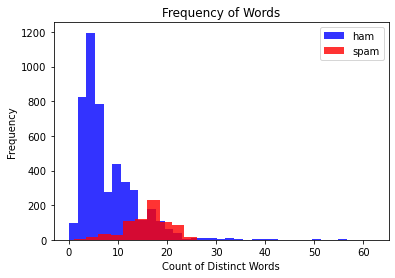

In [17]:
df[df.Category=='ham'].Distinct_Words.plot(bins=35, kind='hist', color='blue', 
                                       label='ham', alpha=0.8)
df[df.Category=='spam'].Distinct_Words.plot(kind='hist', color='red', 
                                       label='spam', alpha=0.8)
plt.legend()
plt.title('Frequency of Words')
plt.xlabel("Count of Distinct Words");

In [18]:
df.head()

,Category,Message,Total_Words,Distinct_Words
0,ham,go jurong point crazi avail bugi n great world...,76,16
1,ham,ok lar joke wif u oni,21,6
2,spam,free entri 2 wkli comp win fa cup final tkt 21...,131,21
3,ham,u dun say earli hor u c alreadi say,35,7
4,ham,nah dont think goe usf live around though,41,8


# Visualization

### WordCloud

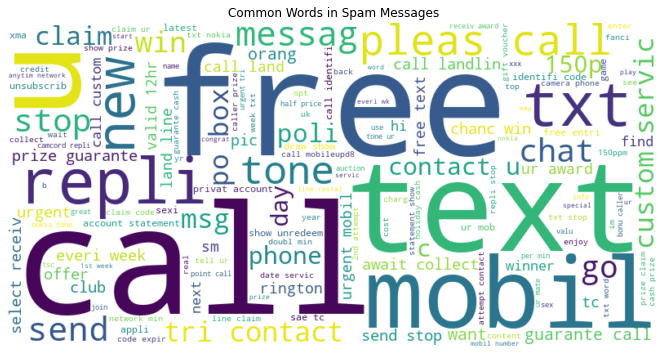

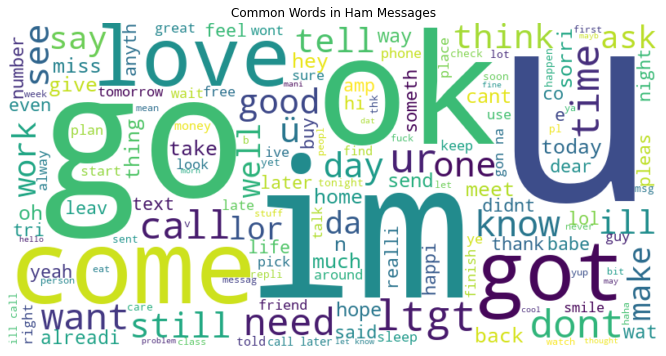

In [19]:
def plot_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=150).generate(text)
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()
    
spam_text = ' '.join(df[df['Category'] == 'spam']['Message'])
ham_text = ' '.join(df[df['Category'] == 'ham']['Message'])

plot_wordcloud(spam_text, 'Common Words in Spam Messages')
plot_wordcloud(ham_text, 'Common Words in Ham Messages')

# Text Vectorization

### LDA Vectors

In [20]:
count_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = count_vectorizer.fit_transform(df['Message'])

In [21]:
n_topics = 10
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda_vectors = lda.fit_transform(dtm)

df['Category_binary'] = df['Category'].map({'spam': 1, 'ham': 0})

In [22]:
# Split the data into training and testing sets
X_train_lda, X_test_lda, y_train_lda, y_test_lda = train_test_split(lda_vectors, df['Category_binary'], test_size=0.2, random_state=42)

In [23]:
# Combine LDA vectors with Total_Words and Distinct_Words as input features
X_lda_combined = pd.concat([pd.DataFrame(lda_vectors), df[['Total_Words', 'Distinct_Words']]], axis=1)

# Split the data into training and testing sets
X_train_lda_combined, X_test_lda_combined, y_train_lda_combined, y_test_lda_combined = train_test_split(X_lda_combined, df['Category_binary'], test_size=0.2, random_state=42)

### Tf-idf Vectors

In [24]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(df['Message'])

X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(tfidf_matrix, df['Category_binary'], test_size=0.2, random_state=42)

In [25]:
total_words = np.array(df['Total_Words']).reshape(-1, 1)
distinct_words = np.array(df['Distinct_Words']).reshape(-1, 1)

# Combine Tf-idf vectors with Total_Words and Distinct_Words as input features
X_tfidf_combined = np.hstack([tfidf_matrix.toarray(), total_words, distinct_words])

# Split the data into training and testing sets
X_train_tfidf_combined, X_test_tfidf_combined, y_train_tfidf_combined, y_test_tfidf_combined = train_test_split(X_tfidf_combined, df['Category_binary'], test_size=0.2, random_state=42)

### Doc2Vec

In [26]:
# Tokenize text
df['Tokenized_Message'] = df['Message'].apply(lambda x: x.lower().split())

# Create TaggedDocument objects for each message
tagged_docs = [TaggedDocument(words=message, tags=[idx]) for idx, message in enumerate(df['Tokenized_Message'])]

# Create Doc2Vec model
vector_size = 100
model = Doc2Vec(tagged_docs, vector_size=vector_size, window=5, min_count=2, epochs=30)

# Create message embeddings
doc2vec_embeddings = np.zeros((len(df), vector_size))
for idx in range(len(df)):
    doc2vec_embeddings[idx] = model.infer_vector(df['Tokenized_Message'][idx])

In [27]:
# Normalize Total_Words and Distinct_Words
scaler = StandardScaler()
additional_features = scaler.fit_transform(df[['Total_Words', 'Distinct_Words']])

# Concatenate doc2Vec_embeddings with Total_Words and Distinct_Words
combined_features = np.concatenate((doc2vec_embeddings, additional_features), axis=1)

# Split the combined_features and labels into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(combined_features, df['Category_binary'], test_size=0.2, random_state=42)

# Modeling and Evaluation

### Logistic Regression (LDA Vectors)

In [28]:
log_reg_lda = LogisticRegression()
log_reg_lda.fit(X_train_lda, y_train_lda)

LogisticRegression()

In [29]:
y_pred_lda = log_reg_lda.predict(X_test_lda)
print(classification_report(y_test_lda, y_pred_lda))

              precision    recall  f1-score   support

           0       0.93      0.98      0.95       966
           1       0.80      0.50      0.62       149

    accuracy                           0.92      1115
   macro avg       0.86      0.74      0.79      1115
weighted avg       0.91      0.92      0.91      1115



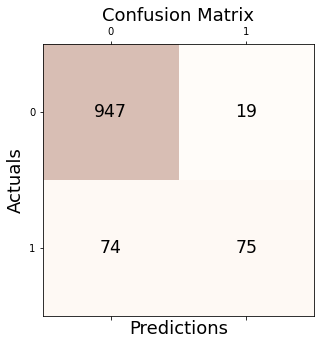

In [30]:
conf_matrix_lda = confusion_matrix(y_true = y_test_lda, y_pred = y_pred_lda)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix_lda, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix_lda.shape[0]):
    for j in range(conf_matrix_lda.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix_lda[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [31]:
topic_coef = pd.DataFrame(log_reg_lda.coef_.T, columns=['Coefficient'])
topic_coef['Topic'] = range(1, n_topics + 1)
topic_coef.sort_values(by='Coefficient', ascending=False, inplace=True)

print(topic_coef)

   Coefficient  Topic
2     5.175083      3
4     2.419161      5
0     1.258472      1
9     0.754803     10
7    -0.252663      8
8    -0.887010      9
3    -1.334249      4
5    -1.597581      6
1    -2.368378      2
6    -3.167800      7


In [32]:
def display_topic_words(lda_model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(lda_model.components_):
        print(f"Topic #{topic_idx + 1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

n_top_words = 10
feature_names = count_vectorizer.get_feature_names()
display_topic_words(lda, feature_names, n_top_words)

Topic #1:
pleas girl cash collect repli went minut need holiday man
Topic #2:
ill later sorri im like come yeah ur night tomorrow
Topic #3:
free mobil txt claim phone prize messag award contact ur
Topic #4:
ok said finish lor lunch alreadi ask come told yup
Topic #5:
ur stop tone week repli free mobil txt send rington
Topic #6:
lor got da home wat ok dun im ur thk
Topic #7:
good day love time work happi got come im oh
Topic #8:
im text na think love miss need like gon wan
Topic #9:
ltgt dont know want pl like tell anyth sent send
Topic #10:
ur im want day new today best friend smoke come


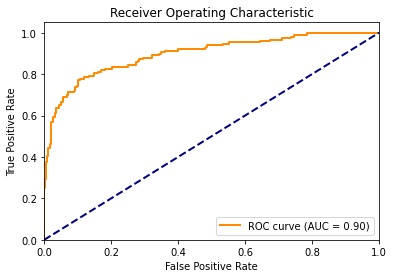

In [33]:
y_prob_lda = log_reg_lda.predict_proba(X_test_lda)[:, 1]

fpr_lda, tpr_lda, _ = roc_curve(y_test_lda, y_prob_lda)
roc_auc_lda = auc(fpr_lda, tpr_lda)

plt.figure()
plt.plot(fpr_lda, tpr_lda, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_lda:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### Logistic Regression (LDA Vectors + Numerical Features)

In [34]:
# Train a logistic regression model on the training set
log_reg_lda_combined = LogisticRegression()
log_reg_lda_combined.fit(X_train_lda_combined, y_train_lda_combined)

# Evaluate the performance of the model on the testing set
y_pred_lda_combined = log_reg_lda_combined.predict(X_test_lda_combined)
print(classification_report(y_test_lda_combined, y_pred_lda_combined))

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       966
           1       0.80      0.66      0.72       149

    accuracy                           0.93      1115
   macro avg       0.88      0.82      0.84      1115
weighted avg       0.93      0.93      0.93      1115



D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


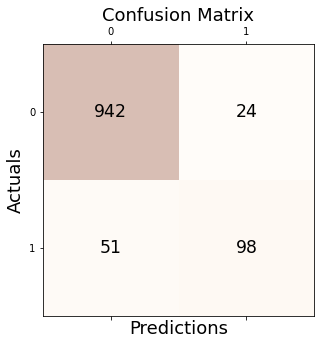

In [35]:
conf_matrix_lda_combined = confusion_matrix(y_true = y_test_lda_combined, y_pred = y_pred_lda_combined)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix_lda_combined, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix_lda_combined.shape[0]):
    for j in range(conf_matrix_lda_combined.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix_lda_combined[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

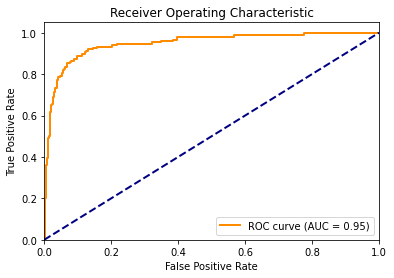

In [36]:
# Generate a ROC curve and compute the AUC score for the model
y_prob_lda_combined = log_reg_lda_combined.predict_proba(X_test_lda_combined)[:, 1]

fpr_lda_combined, tpr_lda_combined, _ = roc_curve(y_test_lda_combined, y_prob_lda_combined)
roc_auc_lda_combined = auc(fpr_lda_combined, tpr_lda_combined)

plt.figure()
plt.plot(fpr_lda_combined, tpr_lda_combined, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_lda_combined:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### Logistic Regression (Tf-Idf Vectors)

In [37]:
log_reg_tfidf = LogisticRegression()
log_reg_tfidf.fit(X_train_tfidf, y_train_tfidf)

LogisticRegression()

In [38]:
y_pred_tfidf = log_reg_tfidf.predict(X_test_tfidf)
print(classification_report(y_test_tfidf, y_pred_tfidf))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       966
           1       1.00      0.65      0.79       149

    accuracy                           0.95      1115
   macro avg       0.97      0.83      0.88      1115
weighted avg       0.96      0.95      0.95      1115



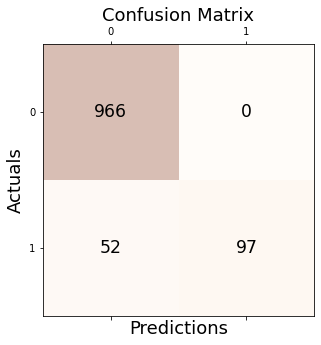

In [39]:
conf_matrix_tfidf = confusion_matrix(y_true = y_test_tfidf, y_pred = y_pred_tfidf)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix_tfidf, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix_tfidf.shape[0]):
    for j in range(conf_matrix_tfidf.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix_tfidf[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

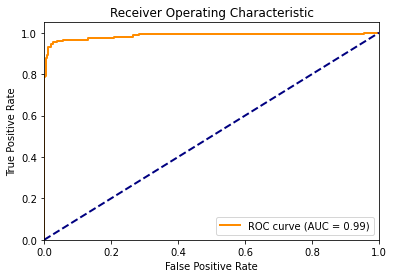

In [40]:
y_prob_tfidf = log_reg_tfidf.predict_proba(X_test_tfidf)[:, 1]

fpr_tfidf, tpr_tfidf, _ = roc_curve(y_test_tfidf, y_prob_tfidf)
roc_auc_tfidf = auc(fpr_tfidf, tpr_tfidf)

plt.figure()
plt.plot(fpr_tfidf, tpr_tfidf, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_tfidf:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### Logistic Regression (Tf-Idf Vectors + Numerical Features)

In [41]:
# Modeling and Evaluation
log_reg_tfidf_combined = LogisticRegression()
log_reg_tfidf_combined.fit(X_train_tfidf_combined, y_train_tfidf_combined)

y_pred_tfidf_combined = log_reg_tfidf_combined.predict(X_test_tfidf_combined)

D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [42]:
print(classification_report(y_test_tfidf_combined, y_pred_tfidf_combined))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       966
           1       0.89      0.79      0.84       149

    accuracy                           0.96      1115
   macro avg       0.93      0.89      0.91      1115
weighted avg       0.96      0.96      0.96      1115



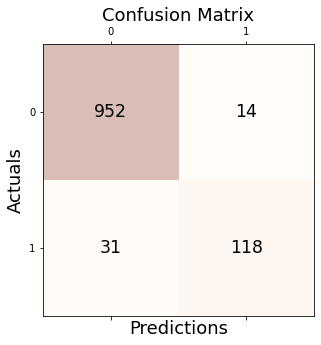

In [43]:
conf_matrix_tfidf_combined = confusion_matrix(y_true = y_test_tfidf_combined, y_pred = y_pred_tfidf_combined)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix_tfidf_combined, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix_tfidf_combined.shape[0]):
    for j in range(conf_matrix_tfidf_combined.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix_tfidf_combined[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

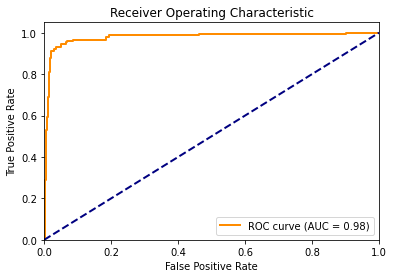

In [44]:
# Generate a ROC curve and compute the AUC score for the model
y_prob_tfidf_combined = log_reg_tfidf_combined.predict_proba(X_test_tfidf_combined)[:, 1]

fpr_tfidf_combined, tpr_tfidf_combined, _ = roc_curve(y_test_tfidf_combined, y_prob_tfidf_combined)
roc_auc_tfidf_combined = auc(fpr_tfidf_combined, tpr_tfidf_combined)

plt.figure()
plt.plot(fpr_tfidf_combined, tpr_tfidf_combined, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_tfidf_combined:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### LSTM

In [45]:
# Reshape the input data to the required shape for LSTM
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [46]:
# Create the LSTM model with combined features
input_shape = (X_train.shape[1], X_train.shape[2])
lstm_model = Sequential()
lstm_model.add(LSTM(100, input_shape=input_shape, activation='relu'))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(1, activation='sigmoid'))

# Compile and train the LSTM model
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [47]:
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights = {i: class_weights[i] for i in range(len(class_weights))}

history = lstm_model.fit(X_train, y_train, epochs=500, batch_size=32, class_weight=class_weights)

Epoch 1/500


D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1], y=1978    1
3989    0
3935    0
4078    0
4086    1
       ..
3772    0
5191    0
5226    0
5390    0
860     0
Name: Category_binary, Length: 4457, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


140/140 [==============================] - 1s 1ms/step - loss: 0.5098 - accuracy: 0.7978
Epoch 2/500
140/140 [==============================] - 0s 1ms/step - loss: 0.2980 - accuracy: 0.8975
Epoch 3/500
140/140 [==============================] - 0s 1ms/step - loss: 0.2482 - accuracy: 0.9179
Epoch 4/500
140/140 [==============================] - 0s 1ms/step - loss: 0.2318 - accuracy: 0.9219
Epoch 5/500
140/140 [==============================] - 0s 1ms/step - loss: 0.2148 - accuracy: 0.9304
Epoch 6/500
140/140 [==============================] - 0s 1ms/step - loss: 0.2040 - accuracy: 0.9361
Epoch 7/500
140/140 [==============================] - 0s 1ms/step - loss: 0.1968 - accuracy: 0.9396
Epoch 8/500
140/140 [==============================] - 0s 1ms/step - loss: 0.1917 - accuracy: 0.9367
Epoch 9/500
140/140 [==============================] - 0s 1ms/step - loss: 0.1856 - accuracy: 0.9453
Epoch 10/500
140/140 [==============================] - 0s 2ms/step - loss: 0.1805 - accuracy: 0.9408
E

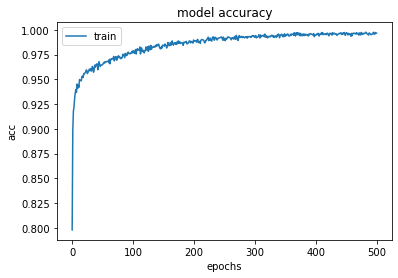

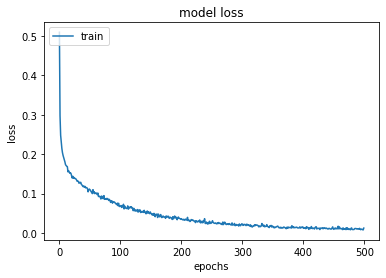

<Figure size 432x288 with 0 Axes>

In [48]:
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('model_accuracy.png')

# summarize history for loss
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('model_loss.png')

In [101]:
# Obtain predictions
y_pred = lstm_model.predict(X_test)
y_pred_classes = (y_pred > 0.7).astype(int)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

35/35 [==============================] - 0s 649us/step


In [102]:
print(classification_report(y_test, y_pred_classes))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       966
           1       0.93      0.88      0.90       149

    accuracy                           0.97      1115
   macro avg       0.96      0.93      0.94      1115
weighted avg       0.97      0.97      0.97      1115



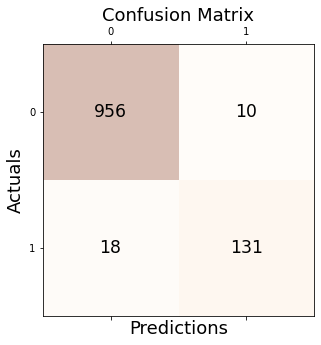

In [103]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(cm, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

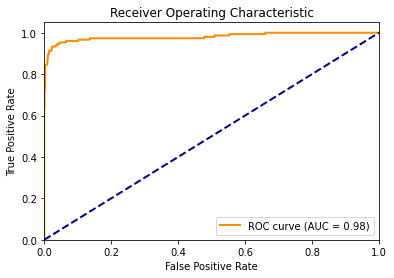

In [104]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc_score = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()